In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures as Poly
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor

import joblib

mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

C:\Users\Guilherme\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def plot_Wm(y_train,y_pred_train,y_test,y_pred_test, Method):
    Aux = np.linspace(10,60)
    plt.figure()
    plt.plot(Aux,0.9*Aux,'k--')
    plt.plot(Aux,1.1*Aux,'k--')
    plt.plot(y_train,y_pred_train,'o',color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,color = '#2ca02c', mfc='none',label = 'Test Set',)
    plt.text(23, 17, '$- 10 \%$', fontsize=12)
    plt.text(19, 28, '$+ 10 \%$', fontsize=12)
    plt.legend()
    plt.ylabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - ' + Method )
    plt.xlabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - Numerical Solution')
    plt.grid(linestyle='dotted')
    plt.savefig('Plots/Wm - '+Method +'.png', format = 'png', bbox_inches='tight',) 

In [3]:
def plot_Qc(y_train,y_pred_train,y_test,y_pred_test, Method):
    Aux = np.linspace(10,300)
    plt.figure()
    plt.plot(Aux,0.9*Aux,'k--')
    plt.plot(Aux,1.1*Aux,'k--')
    plt.plot(y_train,y_pred_train,'o',color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,color = '#2ca02c', mfc='none',label = 'Test Set')
    plt.text(140, 180, '$+ 10 \%$', fontsize=12)
    plt.text(150, 120, '$- 10 \%$', fontsize=12)
    plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - ' + Method )
    plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Target')
    plt.legend()
    plt.grid(linestyle='dotted')
    plt.savefig('Plots/Qc - '+Method +'.png', format = 'png', bbox_inches='tight',) 

### Reading the Input Parameteres 

In [4]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0) # Input Data

# Train-Test Split

In [5]:
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

In [6]:
def ML_Model(X_train,y_train,X_test,y_test,Algo,Obj):
    
    if Algo == 'Ridge1':
        model = make_pipeline(Poly(degree=1, interaction_only = False),Ridge(alpha=0.5))
        param = {}
        
    elif Algo == 'Ridge2':
        model = make_pipeline(Poly(degree=2, interaction_only = False),Ridge(alpha=0.5))
        param = {}
        
    elif Algo == 'Ridge3':
        model = make_pipeline(Poly(degree=3, interaction_only = False),Ridge(alpha=0.5))
        param = {}
        
    elif Algo == 'Ridge4':
        model = make_pipeline(Poly(degree=4, interaction_only = False),Ridge(alpha=0.5))
        param = {}
        
    elif Algo == 'KNN':
        param = {'n_neighbors': [1,5,10,20,50,100],
                 'leaf_size': [1,5,10,20,50,100],
                 'p': [1,3,5],
                 'weights': ('uniform', 'distance'),
                 'metric': ('minkowski', 'chebyshev'),
                }
        model = KNeighborsRegressor(algorithm='auto')
    
    elif Algo == 'RF':
        param = {'n_estimators': [5,25,50,100],
                 'max_features': ['auto', 'sqrt'],
                 'max_depth': [5,10,50],
                 'min_samples_split': [2,6,10],
                 'min_samples_leaf' : [1,3,5]
                }
        model = RandomForestRegressor(random_state=42)
    
    elif Algo =='SVR':
        param = {'kernel':['linear','poly'],
                 'C':[1,10],
                 'gamma': [1e-2, 1e-1],
                 'epsilon':[0.1, 0.2]
                  }
        model = SVR()
    
    elif Algo == 'XGBoost':
        param = {'objective':['reg:squarederror'],
                 'learning_rate': [0.01, 0.02],
                 'max_depth': [5, 6, 7],
                 'min_child_weight': [1,3],
                 'alpha' :[1,5],
                 'gamma': [1,2],
                 'subsample': [0.5, 0.75],
                 'colsample_bytree': [0.75,1],
                 'n_estimators': [500, 1000]
                }
        model = XGBRegressor()
        
    model = GridSearchCV(model,
                         param_grid=param,
                         scoring = 'r2',
                         verbose = 1
                        )
    if Obj == 'Qc':
        model.fit(X_train, y_train['Qc'])
        print('The coefficient of determination for '+ Obj +' Training Set using '+ Algo +' is '+
              str(r2_score(y_train[Obj],model.predict(X_train).T)))
        print('The coefficient of determination for '+ Obj +' Test Set using '+ Algo +' is '+
              str(r2_score(y_test[Obj], model.predict(X_test).T)))
        
        plot_Qc(y_train['Qc'], 
                model.predict(X_train).T,
                y_test['Qc'],
                model.predict(X_test).T,
                Algo)
        
    elif Obj =='Wm':
        model.fit(X_train, y_train['Wm'])
        
        print('The coefficient of determination for' + Obj +' Training Set using '+ Algo +' is '+
              str(r2_score(y_train[Obj],model.predict(X_train).T)))
        print('The coefficient of determination for '+ Obj +' Test Set using '+ Algo +' is '+
              str(r2_score(y_test[Obj], model.predict(X_test).T)))
        plot_Wm(y_train['Wm'],
                model.predict(X_train).T,
                y_test['Wm'],
                model.predict(X_test).T,
                Algo)
        
    print(Obj,Algo)
    joblib.dump(model, 'Models/'+Obj+'_'+Algo+'.pkl')
    return r2_score(y_train[Obj],model.predict(X_train).T),r2_score(y_test[Obj], model.predict(X_test).T)

In [7]:
Algo = ['Ridge1','Ridge2','Ridge3','Ridge4','KNN','RF','SVR','XGBoost']

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The coefficient of determination for Qc Training Set using Ridge1 is 0.8885910303422555
The coefficient of determination for Qc Test Set using Ridge1 is 0.877878706472577
Qc Ridge1
Fitting 5 folds for each of 1 candidates, totalling 5 fits
The coefficient of determination forWm Training Set using Ridge1 is 0.9745759124709458
The coefficient of determination for Wm Test Set using Ridge1 is 0.9726272926115422
Wm Ridge1
Fitting 5 folds for each of 1 candidates, totalling 5 fits
The coefficient of determination for Qc Training Set using Ridge2 is 0.990924262340603
The coefficient of determination for Qc Test Set using Ridge2 is 0.9929569605455664
Qc Ridge2
Fitting 5 folds for each of 1 candidates, totalling 5 fits
The coefficient of determination forWm Training Set using Ridge2 is 0.9990548914674248
The coefficient of determination for Wm Test Set using Ridge2 is 0.999092060047069
Wm Ridge2
Fitting 5 folds for each of 1 candidates,

C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.52909e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.43943e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.55404e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.45742e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\

Qc Ridge3
Fitting 5 folds for each of 1 candidates, totalling 5 fits
The coefficient of determination forWm Training Set using Ridge3 is 0.999799987136918
The coefficient of determination for Wm Test Set using Ridge3 is 0.9995876064444003


C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.52909e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.43943e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.55404e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.45742e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\

Wm Ridge3
Fitting 5 folds for each of 1 candidates, totalling 5 fits
The coefficient of determination for Qc Training Set using Ridge4 is 0.9881337394028719
The coefficient of determination for Qc Test Set using Ridge4 is 0.9794580562597117


C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-pa

Qc Ridge4
Fitting 5 folds for each of 1 candidates, totalling 5 fits
The coefficient of determination forWm Training Set using Ridge4 is 0.9970961973466593
The coefficient of determination for Wm Test Set using Ridge4 is 0.996448041196299


C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Guilherme\Anaconda3\lib\site-pa

Wm Ridge4
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
The coefficient of determination for Qc Training Set using KNN is 1.0
The coefficient of determination for Qc Test Set using KNN is 0.2372938794303978
Qc KNN
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
The coefficient of determination forWm Training Set using KNN is 1.0
The coefficient of determination for Wm Test Set using KNN is 0.6048255875078221
Wm KNN
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

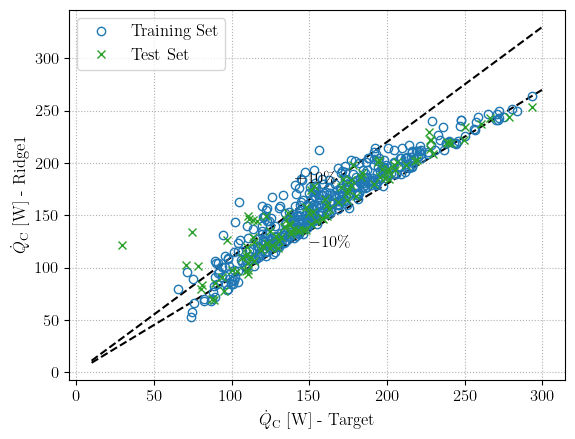

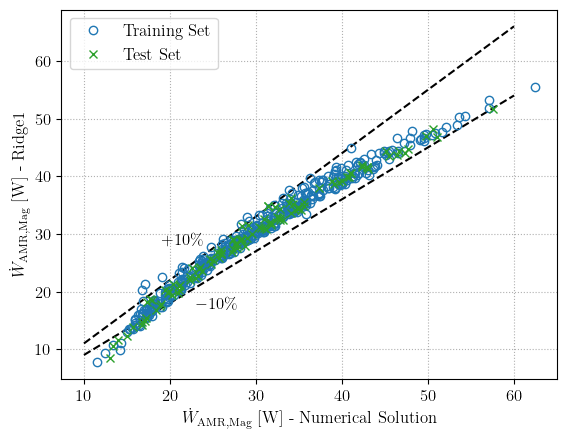

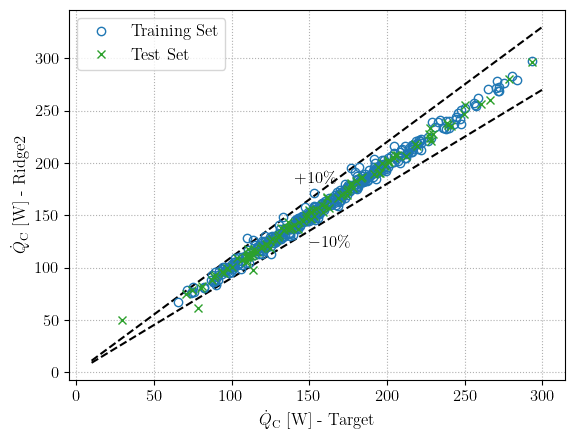

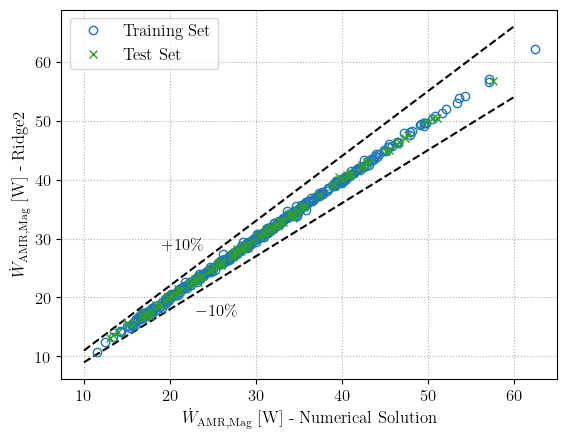

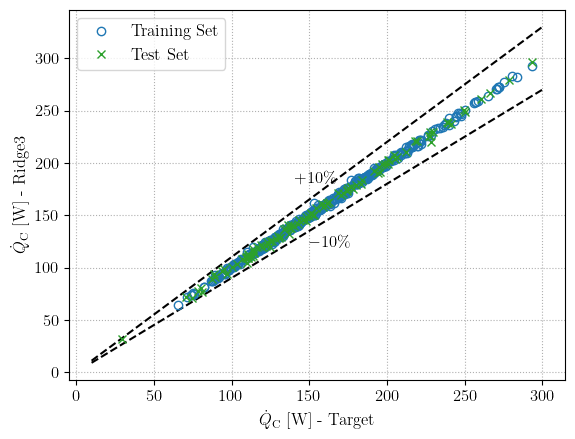

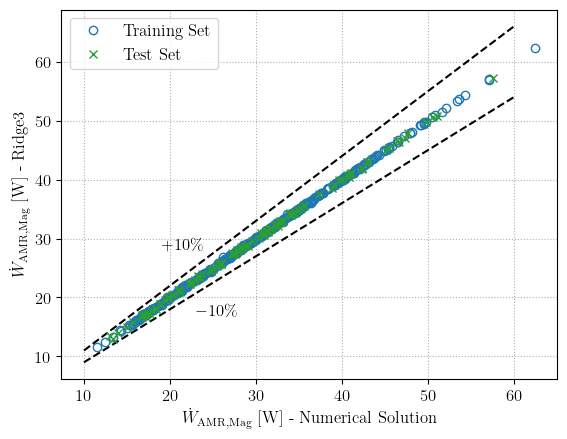

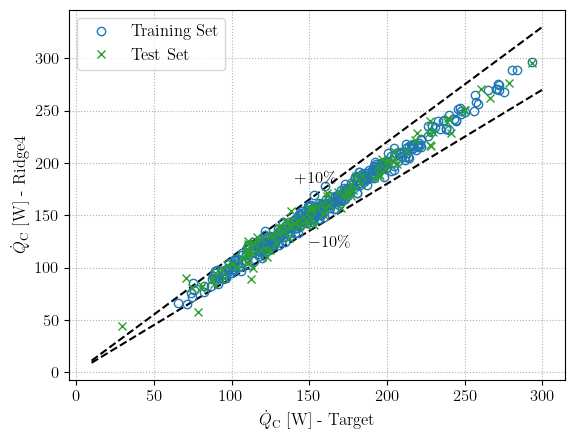

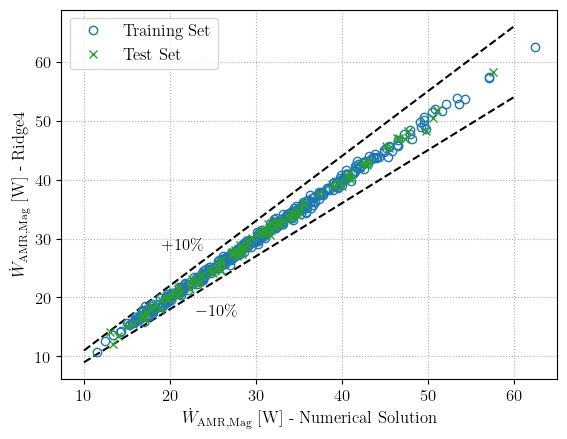

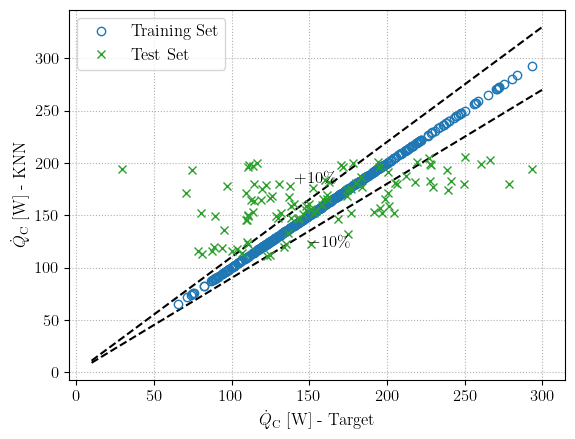

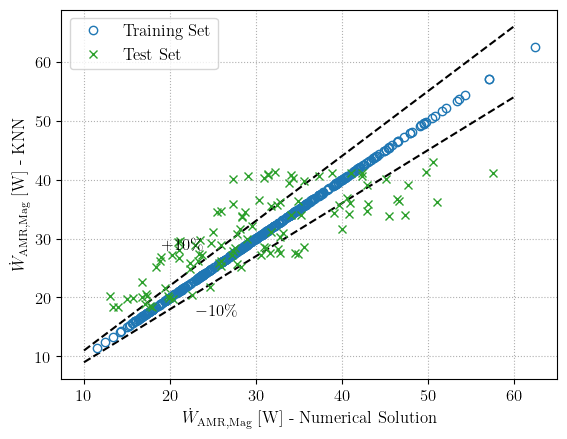

In [8]:
R2_Qc = []
R2_Wm = []
for i in Algo:
        R2_Qc.append(ML_Model(X_train,y_train,X_test,y_test,str(i),'Qc'))
        R2_Wm.append(ML_Model(X_train,y_train,X_test,y_test,str(i),'Wm'))

In [ ]:
pd.DataFrame(R2_Qc, 
             columns = ['Train','Test'],
             index = Algo
            ).to_excel('R2_Qc.xlsx')

pd.DataFrame(R2_Wm, 
             columns = ['Train','Test'],
             index = Algo
            ).to_excel('R2_Wm.xlsx')